In [1]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.datasets import mnist


#load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [2]:
import numpy as np

def create_image(mnist_image):
    #create 72x72 canvas
    canvas = np.zeros((72,72), dtype=np.uint8)

    #resize mnist image to random size between 14x14 and 36x36
    random_size = np.random.randint(14, 36)
    mnist_image = cv2.resize(mnist_image, (random_size, random_size))

    #paste mnist image to random location on canvas
    x_offset = np.random.randint(0, 72-random_size)
    y_offset = np.random.randint(0, 72-random_size)
    canvas[y_offset:y_offset+random_size, x_offset:x_offset+random_size] = mnist_image

    #get object location in canvas coordinates for R-CNN training
    x_min = x_offset / 72
    y_min = y_offset / 72
    x_max = (x_offset + random_size) / 72
    y_max = (y_offset + random_size) / 72

    location = [x_min, y_min, x_max, y_max]

    return canvas, location

0.4444444444444444 0.041666666666666664 0.7777777777777778 0.375


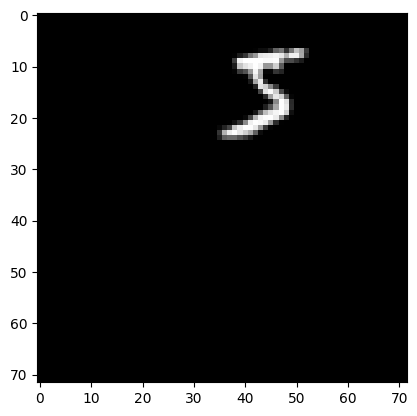

In [3]:
temp,location = create_image(x_train[0])
plt.imshow(temp, cmap='gray')
print(*location)

In [4]:
from tqdm import tqdm


temp_x_train = np.ndarray((x_train.shape[0], 72, 72), dtype=np.uint8)
locations_train = np.ndarray((x_train.shape[0], 4), dtype=np.float32)

for i in tqdm(range(x_train.shape[0])):
    temp_x_train[i], label = create_image(x_train[i])
    locations_train[i] = label

x_train = temp_x_train

temp_x_test = np.ndarray((x_test.shape[0], 72, 72), dtype=np.uint8)
locations_test = np.ndarray((x_test.shape[0], 4), dtype=np.float32)

for i in tqdm(range(x_test.shape[0])):
    temp_x_test[i], label = create_image(x_test[i])
    locations_test[i] = label

x_test = temp_x_test

100%|██████████| 10000/10000 [00:00<00:00, 89285.91it/s]


# Train R-CNN with TensorFlow

In [5]:
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical


def iou(y_true, y_pred):
    # Define the intersection and the union
    xA = K.maximum(y_true[:, 0], y_pred[:, 0])
    yA = K.maximum(y_true[:, 1], y_pred[:, 1])
    xB = K.minimum(y_true[:, 2], y_pred[:, 2])
    yB = K.minimum(y_true[:, 3], y_pred[:, 3])

    # Calculate the area of intersection
    interArea = K.maximum(0.0, xB - xA) * K.maximum(0.0, yB - yA)

    # Calculate the area of both rectangles
    boxAArea = (y_true[:, 2] - y_true[:, 0]) * (y_true[:, 3] - y_true[:, 1])
    boxBArea = (y_pred[:, 2] - y_pred[:, 0]) * (y_pred[:, 3] - y_pred[:, 1])

    # Calculate the area of union
    union = (boxAArea + boxBArea) - interArea

    # Calculate the IOU
    iou = interArea / union

    return iou

# Define R-CNN model
def RCNN(image):
    x = Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 1))(image)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x_1 = Flatten()(x)
    x_1 = Dense(64, activation='relu')(x_1)
    x_1 = Dense(4)(x_1)

    x_2 = Flatten()(x)
    x_2 = Dense(64, activation='relu')(x_2)
    x_2 = Dense(10)(x_2)

    return x_1, x_2

input_shape = (72, 72, 1)
image_input = Input(shape=input_shape)
output_1, output_2 = RCNN(image_input)

model = Model(inputs=image_input, outputs=[output_1, output_2])
optimizer = Adam(lr=0.001)

# Compile the model with IOU loss function
model.compile(optimizer=optimizer, loss=[iou, 'categorical_crossentropy'], metrics=[])


# Reshape data for CNN input
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Normalize pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train_onehot = to_categorical(y_train, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

# Train the model
model.fit(x_train, [locations_train, y_train_onehot], epochs=5, batch_size=32, validation_data=(x_test, [locations_test, y_test_onehot]))

# Evaluate the model
loss = model.evaluate(x_test, [locations_test, y_test_onehot])
print("Test Loss:", loss)
 

c:\Users\Emre\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5


KeyboardInterrupt: 

In [ ]:
#write a function to predict bounding box coordinates
def predict_bounding_box_and_label(image):
    #resize image to 72x72
    image = cv2.resize(image, (72, 72))

    #reshape and normalize pixel values
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255

    #predict bounding box coordinates
    bounding_box, label  = model.predict(image)[0]

    return bounding_box, label

In [ ]:
test_image = x_test[6]
bounding_box , label = predict_bounding_box(test_image)

#draw bounding box on test image
image = np.squeeze(test_image)
image = cv2.resize(image, (72, 72))
image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

#convert normalized coordinates to pixel values
x_min = int(bounding_box[0] * 72)
y_min = int(bounding_box[1] * 72)
x_max = int(bounding_box[2] * 72)
y_max = int(bounding_box[3] * 72)

#draw bounding box
image = cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 1)

plt.imshow(image)

1/1 [==============================] - 0s 15ms/step


ValueError: not enough values to unpack (expected 2, got 1)

In [2]:
import os,cv2,keras
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.datasets import mnist
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical

# load mnist dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

import numpy as np

def create_image(mnist_image):
    # create 72x72 canvas
    canvas = np.zeros((72,72), dtype=np.uint8)

    # resize mnist image to random size between 14x14 and 36x36
    random_size = np.random.randint(14, 36)
    mnist_image = cv2.resize(mnist_image, (random_size, random_size))

    # paste mnist image to random location on canvas
    x_offset = np.random.randint(0, 72-random_size)
    y_offset = np.random.randint(0, 72-random_size)
    canvas[y_offset:y_offset+random_size, x_offset:x_offset+random_size] = mnist_image

    # get object location in canvas coordinates for R-CNN training
    x_min = x_offset / 72
    y_min = y_offset / 72
    x_max = (x_offset + random_size) / 72
    y_max = (y_offset + random_size) / 72

    location = [x_min, y_min, x_max, y_max]

    return canvas, location

temp_x_train = np.ndarray((x_train.shape[0], 72, 72), dtype=np.uint8)
locations_train = np.ndarray((x_train.shape[0], 4), dtype=np.float32)

for i in tqdm(range(x_train.shape[0])):
    temp_x_train[i], label = create_image(x_train[i])
    locations_train[i] = label

x_train = temp_x_train

temp_x_test = np.ndarray((x_test.shape[0], 72, 72), dtype=np.uint8)
locations_test = np.ndarray((x_test.shape[0], 4), dtype=np.float32)

for i in tqdm(range(x_test.shape[0])):
    temp_x_test[i], label = create_image(x_test[i])
    locations_test[i] = label

x_test = temp_x_test

import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow.keras.backend as K

def iou(y_true, y_pred):
    # Define the intersection and the union
    xA = K.maximum(y_true[0][0], y_pred[0][0]) 
    yA = K.maximum(y_true[0][1], y_pred[0][1])
    xB = K.minimum(y_true[0][2], y_pred[0][2])
    yB = K.minimum(y_true[0][3], y_pred[0][3])

    # Calculate the area of intersection
    interArea = K.maximum(0.0, xB - xA) * K.maximum(0.0, yB - yA)

    # Calculate the area of both rectangles
    boxAArea = (y_true[0][2] - y_true[0][0]) * (y_true[0][3] - y_true[0][1])
    boxBArea = (y_pred[0][2] - y_pred[0][0]) * (y_pred[0][3] - y_pred[0][1])

    # Calculate the area of union
    union = (boxAArea + boxBArea) - interArea

    # Calculate the IOU
    iou = interArea / union

    return 1-iou

# Define R-CNN model
def RCNN(image):
    x = Conv2D(32, (3, 3), activation='relu', input_shape=(72, 72, 1))(image)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    
    # Output for bounding box prediction
    bounding_box_output = Dense(4, activation= 'sigmoid', name = 'bounding_box')(x)

    # Output for label prediction
    label_output = Dense(10, activation='softmax', name = 'class_label')(x)

    return bounding_box_output, label_output

input_shape = (72, 72, 1)
image_input = Input(shape=input_shape)
output_1, output_2 = RCNN(image_input)

model = Model(inputs=image_input, outputs=[output_1, output_2])
optimizer = Adam(lr=0.001)

losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": iou
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

trainTargets = {
    "class_label": y_train_encoded,
    "bounding_box": locations_train
}

testTargets = {
    "class_label": y_test_encoded,
    "bounding_box": locations_test
}

# Compile the model with IOU loss function
model.compile(optimizer=optimizer, loss=losses, metrics=['accuracy'], loss_weights=lossWeights)

print(model.summary())

# Reshape data for CNN input
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Normalize pixel values to range [0, 1]
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Train the model
model.fit(x_train, trainTargets, epochs=5, batch_size=32, validation_data=(x_test, testTargets))


100%|██████████| 10000/10000 [00:00<00:00, 89552.23it/s]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 72, 72, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 70, 70, 32)   320         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 35, 35, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 33, 33, 64)   18496       ['max_pooling2d[0][0]']          
                                                                                              

c:\Users\Emre\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/5
1875/1875 [==============================] - 13s 5ms/step - loss: 1.6302 - bounding_box_loss: 0.8518 - class_label_loss: 0.7783 - bounding_box_accuracy: 0.6105 - class_label_accuracy: 0.7329 - val_loss: 1.0823 - val_bounding_box_loss: 0.7171 - val_class_label_loss: 0.3652 - val_bounding_box_accuracy: 0.8700 - val_class_label_accuracy: 0.8881
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.8572 - bounding_box_loss: 0.6004 - class_label_loss: 0.2568 - bounding_box_accuracy: 0.8567 - class_label_accuracy: 0.9277 - val_loss: 0.7139 - val_bounding_box_loss: 0.5111 - val_class_label_loss: 0.2029 - val_bounding_box_accuracy: 0.9125 - val_class_label_accuracy: 0.9417
Epoch 3/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6007 - bounding_box_loss: 0.4401 - class_label_loss: 0.1606 - bounding_box_accuracy: 0.9205 - class_label_accuracy: 0.9544 - val_loss: 0.5423 - val_bounding_box_loss: 0.4159 - val_class_label_loss: 0.1264 - val

In [3]:
# Evaluate the model
loss = model.evaluate(x_test, testTargets)
print("Test Loss:", loss)

# Write a function to predict bounding box coordinates
def predict_bounding_box_and_label(image):
    # Resize image to 72x72
    image = cv2.resize(image, (72, 72))

    # Reshape and normalize pixel values
    image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    image = image.astype('float32') / 255

    # Predict bounding box coordinates
    bounding_box, label = model.predict(image)
    
    return bounding_box, label



313/313 [==============================] - 1s 3ms/step - loss: 0.4256 - bounding_box_loss: 0.3212 - class_label_loss: 0.1045 - bounding_box_accuracy: 0.9494 - class_label_accuracy: 0.9668
Test Loss: [0.42563074827194214, 0.3211584985256195, 0.10447245091199875, 0.949400007724762, 0.9667999744415283]


In [6]:
def test(i):
    test_image = x_test[i]
    bounding_box , label = predict_bounding_box_and_label(test_image)

    # draw bounding box on test image
    image = np.squeeze(test_image)
    image = cv2.resize(image, (72, 72))
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # convert normalized coordinates to pixel values
    x_min = int(bounding_box[0][0] * 72)
    y_min = int(bounding_box[0][1] * 72)
    x_max = int(bounding_box[0][2] * 72)
    y_max = int(bounding_box[0][3] * 72)

    print("Predicted Label:", np.argmax(label))
    print("Bounding Box Coordinates:", bounding_box)
    #print actual label
    print("Actual Label:", y_test[i])
    print("Actual Bounding Box Coordinates:", locations_test[i])


    # draw bounding box
    # Adjusting coordinates to match the format expected by cv2.rectangle
    top_left = (x_min, y_min)
    bottom_right = (x_max, y_max)
    image = cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 1)

    plt.imshow(image)
    plt.show()


1/1 [==============================] - 0s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted Label: 1
Bounding Box Coordinates: [[0.41371313 0.31117204 0.65524626 0.58643466]]
Actual Label: 4
Actual Bounding Box Coordinates: [0.33333334 0.30555555 0.7916667  0.7638889 ]


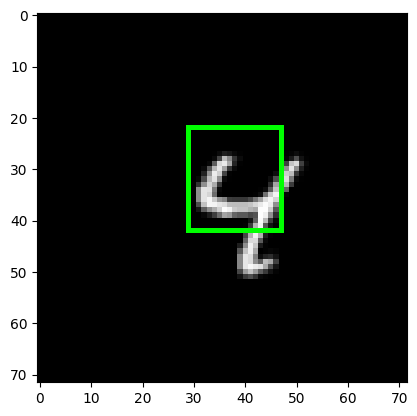

In [7]:
test(6)